# Task description

Given a dataset for product type classification, the task is to build a model to predict the column label, using the other columns as input.

Column explanations:
- sku_id – product id
- country_name – name of the country in which the product was found
- retailer – name of the retailer in which the product was found
- breadcrumbs – breadcrumbs, where breadcrumbs show the path of the product in the retailer
taxonomy tree
- breadcrumbs_t – translated breadcrumbs
- name – name of the product
- name_t – translated name
- pack_size – pack size field of the product
- pack_size_t – translated pack size
- description_short – product description, possibly truncated to keep maximum length fixed
- description_t_short – translated description
- resnet50_labels_005 – categories predicted by an image classifier, thresholded at 0.05 confidence
- resnet50_labels_06 – categories predicted by an image classifier, thresholded at 0.6 confidence
- price – price of the product in USD
- label – product type, this is the target to predict

# Make necessary imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, KBinsDiscretizer, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold

from sklearn import set_config, metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# Load data

In [2]:
df = pd.read_csv('data/products/train.csv')

df.head()

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label
0,5391778,USA,CVS,"[""Household & Grocery"",""School & Office Suppli...","[""Household & Grocery"",""School & Office Suppli...",Pilot G2 Fine Point Rolling Ball Gel Pens Black,Pilot G2 Fine Point Rolling Ball Gel Pens Black,5 EA,5 EA,gel ink. america's no. 1 selling gel pen (sour...,gel ink. america's no. 1 selling gel pen (sour...,carpenter's_kit~comic_book~screwdriver,screwdriver,8.29,OUT OF SCOPE
1,5908751,USA,CVS,"[""Sexual Health"",""Moisturizers & Lubricants""]","[""Sexual Health"",""Moisturizers & Lubricants""]","K-Y Liquid Personal Water Based Lubricant, 2.5 OZ","K-Y Liquid Personal Water Based Lubricant, 2.5 OZ",2.5 OZ,2.5 OZ,from the #1 doctor recommended and most truste...,from the #1 doctor recommended and most truste...,lotion~nipple~paper_towel~plastic_bag~sunscreen,NaN,9.29,OUT OF SCOPE
2,20197418,USA,CVS,"[""Home Health Care"",""Braces & Supports""]","[""Home Health Care"",""Braces & Supports""]",Scott Specialties Lumbosacral Support with Ins...,Scott Specialties Lumbosacral Support with Ins...,1 CT,1 CT,36 in. to 44 in.white colorthis double-ply 3-p...,36 in. to 44 in.white colorthis double-ply 3-p...,cocktail_shaker~hoopskirt~lampshade,NaN,31.99,OUT OF SCOPE
3,20840765,USA,CVS,"[""Household & Grocery"",""Outdoor & Garden""]","[""Household & Grocery"",""Outdoor & Garden""]",OFF! Deep Woods Insect Repellent Towelettes wi...,OFF! Deep Woods Insect Repellent Towelettes wi...,12 CT,12 CT,off! deep woods towelettes are formulated with...,off! deep woods towelettes are formulated with...,packet~web_site,NaN,7.29,OUT OF SCOPE
4,120858,USA,CVS,"[""Vitamins"",""Herbals""]","[""Vitamins"",""Herbals""]",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49,OUT OF SCOPE


In [3]:
df.tail()

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label
4973,158187042,United Arab Emirates,Carrefour,"[""Fresh Food"",""Dairy & Eggs"",""Yoghurt & Chille...","[""Fresh Food"",""Dairy & Eggs"",""Yoghurt"",""Plain ...",Al Rawabi Fresh Yoghurt Low Fat 90g,Al Rawabi Fresh yogurt Low Fat 90g,90g,90g,100% pure cow's milk. milk is good source of c...,the al rawabi fresh yogurt low fat weighs 90g....,bucket~lotion~measuring_cup~nipple~paper_towel...,NaN,0.217984,Plain Yoghurt
4974,214040377,United Arab Emirates,Nespresso,"[""Accessories"",""Original""]","[""Accessories"",""Original""]","Touch travel mug, Limited Edition Festive","Touch travel mug, Limited Edition Festive",NaN,NaN,touch travel mug is a must-have coffee accesso...,touch travel mug is a must-have coffee accesso...,breastplate~bucket~coffeepot~drum~space_heater,NaN,26.975477,OUT OF SCOPE
4975,64366667,United Arab Emirates,Net-A-Porter,"[""Clothing"",""Pants"",""Cropped""]","[""Clothing"",""Pants"",""Cropped""]",Tatum stretch-twill striped pants,Tatum stretch-twill striped pants,NaN,NaN,cefinn tatum stretch-twill striped pants £167,cefinn tatum stretch-twill striped pants ps167,pajama~suit~swimming_trunks~velvet,NaN,210.728950,OUT OF SCOPE
4976,57031623,United Arab Emirates,LuLu Webstore,"[""Health & Beauty"",""Shower & Bath""]","[""Health & Beauty"",""Shower & Bath""]",Home Mate Bath Cap 924 1pc,Home Mate Bath Cap 924 1pc,1 Pc,1 Pc,bath cap soft and comfortable,bath cap soft and comfortable,shower_cap,shower_cap,1.089918,OUT OF SCOPE
4977,199697125,United Arab Emirates,LuLu Webstore,"[""Fresh Food"",""Dairy, Eggs & Cheese"",""Fresh Da...","[""Fresh Food"",""Dairy, Eggs & Cheese"",""Fresh Da...",Activia Stirred Yoghurt Plain 125g,Activia Stirred Yoghurt Plain 125g,1 pc,1 pc,"stirred yoghurt plain , product description co...","stirred yoghurt plain , product description co...",ashcan~lotion~packet~paper_towel,NaN,0.435967,Plain Yoghurt


# Explore data

In [4]:
df_stat1 = pd.DataFrame({'n_unique': df.nunique(), 'n_missing': df.isna().sum(), 'ratio_missing': df.isna().sum()/len(df)})
df_stat2 = df.describe()

print('Shape:', df.shape)
print('# duplicate:', df.duplicated(subset=None, keep='first').sum())
print()
df.info()
print()
print(df_stat1)
print()
print(df_stat2)

Shape: (4978, 15)
# duplicate: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4978 entries, 0 to 4977
Data columns (total 15 columns):
sku_id                 4978 non-null int64
country_name           4978 non-null object
retailer               4978 non-null object
breadcrumbs            4978 non-null object
breadcrumbs_t          4978 non-null object
name                   4978 non-null object
name_t                 4978 non-null object
pack_size              894 non-null object
pack_size_t            892 non-null object
description_short      3755 non-null object
description_t_short    3753 non-null object
resnet50_labels_005    4857 non-null object
resnet50_labels_06     1620 non-null object
price                  4780 non-null float64
label                  4978 non-null object
dtypes: float64(1), int64(1), object(13)
memory usage: 583.4+ KB

                     n_unique  n_missing  ratio_missing
sku_id                   4978          0       0.000000
country_name           

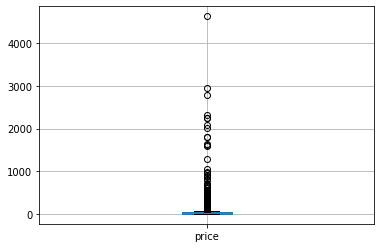

In [5]:
# let's examine distribution of the numerical data
df.boxplot(column=['price'])
plt.show()


It can be seen that the distribution is skewed.

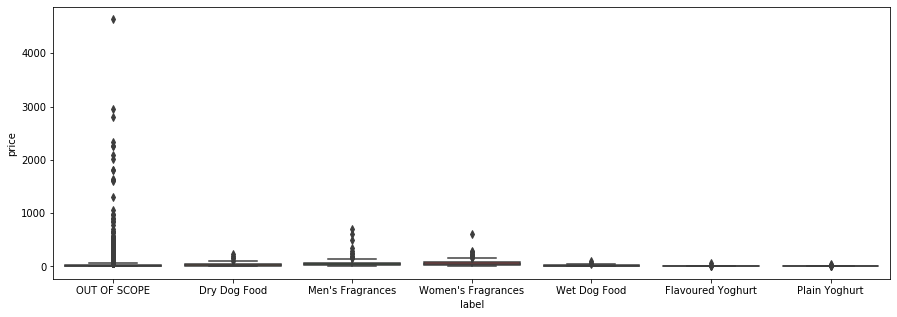

In [6]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(data=df, x='label', y='price')
plt.show()

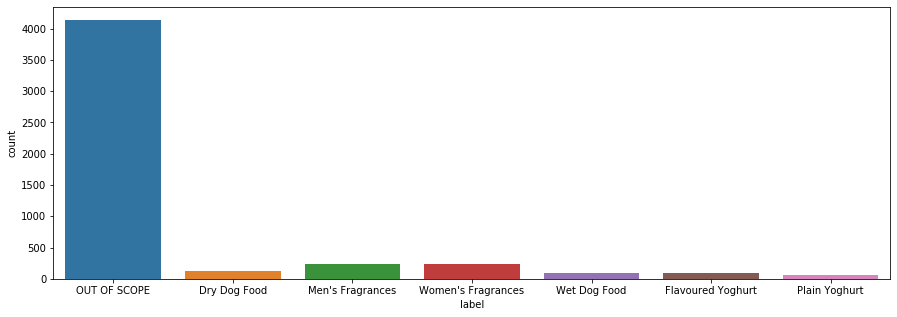

In [7]:
# Let's explore the distribution of class label
plt.figure(figsize=(15,5))
ax = sns.countplot(x="label", data=df)

In [8]:
df['label'].value_counts()

OUT OF SCOPE          4139
Women's Fragrances     233
Men's Fragrances       231
Dry Dog Food           129
Flavoured Yoghurt       95
Wet Dog Food            89
Plain Yoghurt           62
Name: label, dtype: int64

# Observations

The column sku_id is uninformative for learning.

There are columns with a large number of missing values.

There are coulmns that provide similar information.

There is a single column with numerical data.

It is a multiclass classification problem with unbalanced class distribution.

# Split data

In [9]:
# encoder for target labels
labelEncoder = LabelEncoder()

X, y = df.iloc[:,:-1], labelEncoder.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# training data
X_train = pd.DataFrame(data=X_train, columns=df.iloc[:,:-1].columns)

# test data
X_test = pd.DataFrame(data=X_test, columns=df.iloc[:,:-1].columns)

# Create pipeline

In [10]:
# create custom transformer

# Custom Transformer that process columns 
class TextProcessor(BaseEstimator, TransformerMixin):
    # Class Constructor 
    def __init__(self):
        pass
    
    # Return self nothing else to do here    
    def fit(self, X, y=None):
        return self 
    
    # Method that describes what we need this transformer to do
    def transform(self, X, y=None):
        return [' '.join(i.tolist()) for i in X]

In [11]:
# define pipeline for numerical columns
numerical_columns = ['price']
numerical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                         ('binarizer', KBinsDiscretizer(n_bins=3, encode='onehot', strategy='kmeans')) ])

# define pipeline for categorical columns
categorical_columns = ['country_name', 'retailer']
categorical_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                           ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')) ])

# define pipeline for text columns
text_columns = ['breadcrumbs_t', 'name_t', 'description_t_short', 'resnet50_labels_005']
text_transformer = Pipeline(steps=[ ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('merger', TextProcessor()),
                                    ('tfidf', TfidfVectorizer()),
                                    ('scaler', MaxAbsScaler()) ])

# define entire preprocessing pipeline 
preprocessor = ColumnTransformer(transformers=[ ('numerical', numerical_transformer, numerical_columns),
                                                ('categorical', categorical_transformer, categorical_columns),
                                                ('text', text_transformer, text_columns) ])    

# define model using One-vs-the-rest (OvR) multiclass/multilabel strategy
# For each classifier, the class is fitted against all the other classes.
classifier = OneVsRestClassifier(LogisticRegression(class_weight='balanced', random_state=23))

# create a complete prediction pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', classifier)])

# HTML representation of pipeline
set_config(display='diagram')
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('binarizer',
                                                                   KBinsDiscretizer(n_bins=3,
                                                                                    strategy='kmeans'))]),
                                                  ['price']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(ha...
                                                 ('text',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('merger',
                                                                   TextProcessor()),
                                                                  ('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('scaler',
                                                                   MaxAbsScaler())]),
                                                  ['breadcrumbs_t', 'name_t',
                                                   'description_t_short',
                                                   'resnet50_labels_005'])])),
                ('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                  random_state=23)))])

# Model selection

In [12]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

# define grid
params = {
    'preprocessor__numerical__imputer__strategy': ['constant', 'median'],
    'preprocessor__numerical__binarizer__n_bins': [3, 4],
    'classifier__estimator__C': [0.5, 1.0]
    }

# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv)

# execute the grid search
grid_result = grid.fit(X_train, y_train)


In [13]:
# report all configurations
print('means:', grid_result.cv_results_['mean_test_score'])
print('stds:', grid_result.cv_results_['std_test_score'])
print()
# report the best configuration
print('best score:', grid_result.best_score_)
print('best params:', grid_result.best_params_)

means: [0.95454657 0.95454657 0.95454657 0.95454657 0.95630411 0.95630411
 0.95630411 0.95630411]
stds: [0.00213601 0.00213601 0.00213601 0.00213601 0.00164574 0.00164574
 0.00164574 0.00164574]

best score: 0.9563041052186907
best params: {'classifier__estimator__C': 1.0, 'preprocessor__numerical__binarizer__n_bins': 3, 'preprocessor__numerical__imputer__strategy': 'constant'}


# Model evaluation

              precision    recall  f1-score   support

           0       0.89      0.85      0.87        20
           1       0.85      0.65      0.74        26
           2       0.92      0.88      0.90        41
           3       0.99      0.99      0.99       834
           4       0.44      0.70      0.54        10
           5       0.83      0.94      0.88        16
           6       0.88      0.90      0.89        49

    accuracy                           0.97       996
   macro avg       0.83      0.84      0.83       996
weighted avg       0.97      0.97      0.97       996



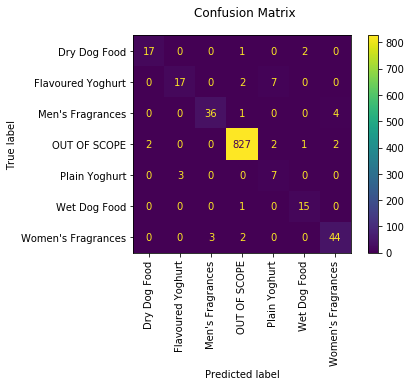

In [14]:
# make prediction
y_pred = grid.predict(X_test)

# create classification report
print(metrics.classification_report(y_test, y_pred))

# compute and show confusion matrix
disp = metrics.plot_confusion_matrix(grid, X_test, y_test, display_labels=labelEncoder.classes_, xticks_rotation='vertical')
disp.figure_.suptitle("Confusion Matrix")
plt.show()